# Predictive Modeling of Race Positions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import datetime as dt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
import matplotlib as plt
import scipy.stats as ss

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('use_inf_as_na', True)

## Import Data and Scrape Weather Data

In [2]:
# Import all the data
drivers_df = pd.read_csv("./f1db_csv/drivers.csv").drop(columns = "url")
lap_times_df = pd.read_csv("./f1db_csv/lap_times.csv")
results_df = pd.read_csv("./f1db_csv/results.csv")
constructors_df = pd.read_csv("./f1db_csv/constructors.csv")
races = pd.read_csv("./f1db_csv/races.csv")

In [4]:
weather = races.iloc[:,[0,1,2]]

# Scrape data for weather
info = []

for link in races.url:
    try:
        df = pd.read_html(link)[0]
        if 'Weather' in list(df.iloc[:,0]):
            n = list(df.iloc[:,0]).index('Weather')
            info.append(df.iloc[n,1])
        else:
            df = pd.read_html(link)[1]
            if 'Weather' in list(df.iloc[:,0]):
                n = list(df.iloc[:,0]).index('Weather')
                info.append(df.iloc[n,1])
            else:
                df = pd.read_html(link)[2]
                if 'Weather' in list(df.iloc[:,0]):
                    n = list(df.iloc[:,0]).index('Weather')
                    info.append(df.iloc[n,1])
                else:
                    df = pd.read_html(link)[3]
                    if 'Weather' in list(df.iloc[:,0]):
                        n = list(df.iloc[:,0]).index('Weather')
                        info.append(df.iloc[n,1])
                    else:
                        driver = webdriver.Chrome()
                        driver.get(link)

                        # click language button
                        button = driver.find_element_by_link_text('Italiano')
                        button.click()
                        
                        clima = driver.find_element_by_xpath('//*[@id="mw-content-text"]/div/table[1]/tbody/tr[9]/td').text
                        info.append(clima) 
                                
    except:
        info.append('not found')

In [5]:
# Create a df just for weather and clean it up
weather['weather'] = info
weather["weather"].iloc[1021] = "Warm, Sunny"
weather["weather"].iloc[1022] = "Warm, Sunny"
weather["weather"].iloc[1023] = "Warm, Sunny"
weather["weather"].iloc[1024] = "Rain, Cloudy"

weather_dict = {'weather_warm': ['soleggiato', 'clear', 'warm', 'hot', 'sunny', 'fine', 'mild', 'sereno'],
               'weather_cold': ['cold', 'fresh', 'chilly', 'cool'],
               'weather_dry': ['dry', 'asciutto'],
               'weather_wet': ['showers', 'wet', 'rain', 'pioggia', 'damp', 'thunderstorms', 'rainy'],
               'weather_cloudy': ['overcast', 'nuvoloso', 'clouds', 'cloudy', 'grey', 'coperto']}

weather_df = pd.DataFrame(columns = weather_dict.keys())

for col in weather_df:
    weather_df[col] = weather['weather'].map(lambda x: 1 if any(i in weather_dict[col] for i in x.lower().split()) else 0)

weather_info = pd.concat([weather, weather_df], axis = 1)
weather_info
weather_info.tail(10)

,raceId,year,round,weather,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy
1025,1038,2020,8,not found,0,0,0,0,0
1026,1039,2020,9,not found,0,0,0,0,0
1027,1040,2020,10,not found,0,0,0,0,0
1028,1041,2020,11,not found,0,0,0,0,0
1029,1042,2020,12,not found,0,0,0,0,0
1030,1043,2020,13,not found,0,0,0,0,0
1031,1044,2020,14,not found,0,0,0,0,0
1032,1045,2020,15,not found,0,0,0,0,0
1033,1046,2020,16,not found,0,0,0,0,0
1034,1047,2020,17,not found,0,0,0,0,0


In [6]:
# Write this to a csv to be used later
weather_info.to_csv("./f1db_csv/weather.csv")

## Merging with other info for a PM dataset

In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

np.set_printoptions(precision=4)

In [19]:
races = pd.read_csv('./f1db_csv/races.csv')
results = pd.read_csv('./f1db_csv/results.csv')
qualifying = pd.read_csv('./f1db_csv/qualifying.csv')
driver_standings = pd.read_csv('./f1db_csv/driver_standings.csv')
constructor_standings = pd.read_csv('./f1db_csv/constructor_standings.csv')
constructors = pd.read_csv('./f1db_csv/constructors.csv')
weather = pd.read_csv('./f1db_csv/weather.csv')
drivers = pd.read_csv('./f1db_csv/drivers.csv')
driver_history = pd.read_csv('./f1db_csv/driver_history.csv')
lap_times = pd.read_csv('./f1db_csv/lap_times.csv')

In [9]:
driver_history.sort_values("raceId")

,Unnamed: 0,driverName,number,nationality,year,name,date,raceId,constructorName,position,minQualifyingTime,racePosition,fastestLapTime,wins,points,driverStanding
7458,7458,Jarno Trulli,NaN,Italian,2009,Australian Grand Prix,2009-03-29,1,Toyota,8,85.265,3.0,88.916,0,6.0,3
7450,7450,Nick Heidfeld,NaN,German,2009,Australian Grand Prix,2009-03-29,1,BMW Sauber,11,85.504,10.0,88.283,0,0.0,10
7456,7456,Sébastien Buemi,NaN,Swiss,2009,Australian Grand Prix,2009-03-29,1,Toro Rosso,16,86.503,7.0,89.230,0,2.0,7
7457,7457,Timo Glock,NaN,German,2009,Australian Grand Prix,2009-03-29,1,Toyota,6,85.281,4.0,88.416,0,5.0,4
7459,7459,Mark Webber,NaN,Australian,2009,Australian Grand Prix,2009-03-29,1,Red Bull,10,85.241,12.0,88.508,0,0.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7438,7438,Sebastian Vettel,5.0,German,2020,Belgian Grand Prix,2020-08-30,1037,Ferrari,14,103.261,13.0,109.958,0,16.0,13
7439,7439,Charles Leclerc,16.0,Monegasque,2020,Belgian Grand Prix,2020-08-30,1037,Ferrari,13,102.996,14.0,107.840,0,45.0,5
7440,7440,Kimi Räikkönen,7.0,Finnish,2020,Belgian Grand Prix,2020-08-30,1037,Alfa Romeo,16,103.743,12.0,109.822,0,0.0,18
7442,7442,Max Verstappen,33.0,Dutch,2020,Belgian Grand Prix,2020-08-30,1037,Red Bull,3,101.778,3.0,108.305,1,110.0,2


In [20]:
# Drop a few columns
# driver_standings.drop(['driver_points_after_race', 'driver_wins_after_race', 'driver_standings_pos_after_race'] ,axis = 1, inplace = True)
# constructor_standings.drop(['constructor_points_after_race', 'constructor_wins_after_race','constructor_standings_pos_after_race' ],axis = 1, inplace = True)

# Merge together to create final df for predictions
df1 = pd.merge(races, weather[["raceId", "weather_warm", "weather_cold", "weather_dry", "weather_wet", "weather_cloudy"]], on=['raceId'])
df2 = pd.merge(df1, results[["raceId", "driverId", "constructorId", "grid", "position", "points", "milliseconds", "laps", "fastestLapSpeed"]], on=['raceId'])
df2 = df2.rename({'position' : 'finishingPosition', 'points' : 'pointsGained'}, axis = 1)
df3 = pd.merge(df2, driver_standings[["raceId", "driverId", "points", "position", "wins"]], on=['raceId', 'driverId'])
df3 = df3.rename({'position' : 'driverStanding', 'points' : 'cumulativePoints', 'wins' : 'driver_wins'}, axis = 1)
df4 = pd.merge(df3, constructor_standings[["raceId", "constructorId", "points", "position", "wins"]], how='left', on=['raceId', 'constructorId']) #from 1958
df4 = df4.rename({'position' : 'constructorStanding', 'points' : 'constructorPoints', 'wins' : 'constructorWins', 'name' : 'raceName'}, axis = 1)
df5 = pd.merge(df4, constructors[["constructorId", "name"]], on = "constructorId")
df5 = df5.rename({'name' : 'constructorName'}, axis = 1)

# Match drivers in driver history table to their driver IDs
drivers["driverName"] = drivers["forename"].str.cat(drivers["surname"],sep = " ")
df6 = pd.merge(driver_history, drivers[["driverName", "driverId"]], on = "driverName")

final_df = pd.merge(df5, df6[["raceId", "driverId", "minQualifyingTime", "fastestLapTime"]], on=['raceId', 'driverId'])
final_df = final_df.drop(columns = ["round", "circuitId", "time", "url", "constructorId"])

# Rearrange the columns so identifying information is at the beginning
key = lambda x: (x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'finishingPosition')
final_df = final_df[sorted(final_df, key=key)]

In [21]:
# Get dummies for categorical variables
df_dum = pd.get_dummies(final_df, columns = ['constructorName'])
# Convert date to datetime
df_dum["date"] = pd.to_datetime(df_dum["date"])
df_dum = df_dum.sort_values("date", ascending = True)
df_dum

,raceId,date,year,raceName,driverId,finishingPosition,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,pointsGained,milliseconds,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,minQualifyingTime,fastestLapTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Arrows,constructorName_BAR,constructorName_BMW Sauber,constructorName_Benetton,constructorName_Brawn,constructorName_Caterham,constructorName_Ferrari,constructorName_Footwork,constructorName_Force India,constructorName_Forti,constructorName_HRT,constructorName_Haas F1 Team,constructorName_Honda,constructorName_Jaguar,constructorName_Jordan,constructorName_Ligier,constructorName_Lotus,constructorName_Lotus F1,constructorName_MF1,constructorName_Manor Marussia,constructorName_Marussia,constructorName_McLaren,constructorName_Mercedes,constructorName_Minardi,constructorName_Prost,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Sauber,constructorName_Spyker,constructorName_Spyker MF1,constructorName_Stewart,constructorName_Super Aguri,constructorName_Toro Rosso,constructorName_Toyota,constructorName_Tyrrell,constructorName_Virgin,constructorName_Williams
1066,224,1996-03-10,1996,Australian Grand Prix,71,1,0,0,1,0,0,2,10.0,5570400,58,\N,10.0,1,1,16.0,1.0,1.0,92.509,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1067,224,1996-03-10,1996,Australian Grand Prix,35,2,0,0,1,0,0,1,6.0,5608420,58,\N,6.0,2,0,16.0,1.0,1.0,92.371,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5938,224,1996-03-10,1996,Australian Grand Prix,77,4,0,0,1,0,0,7,3.0,5647437,58,\N,3.0,4,0,3.0,3.0,0.0,94.344,NaN,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4962,224,1996-03-10,1996,Australian Grand Prix,49,8,0,0,1,0,0,9,0.0,\N,57,\N,0.0,8,0,0.0,7.0,0.0,94.494,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
6022,224,1996-03-10,1996,Australian Grand Prix,64,10,0,0,1,0,0,20,0.0,\N,56,\N,0.0,10,0,0.0,6.0,0.0,96.298,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7411,1037,2020-08-30,2020,Belgian Grand Prix,825,17,0,0,0,0,1,20,0.0,5134301,44,233.287,1.0,17,0,1.0,9.0,0.0,104.314,108.083,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1487,1037,2020-08-30,2020,Belgian Grand Prix,849,16,0,0,0,0,1,19,0.0,5126556,44,233.362,0.0,19,0,0.0,10.0,0.0,104.138,108.048,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1488,1037,2020-08-30,2020,Belgian Grand Prix,847,\N,0,0,0,0,1,15,0.0,\N,9,225.624,0.0,20,0,0.0,10.0,0.0,103.468,111.754,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3867,1037,2020-08-30,2020,Belgian Grand Prix,20,13,0,0,0,0,1,14,0.0,5121655,44,229.309,16.0,13,0,61.0,5.0,0.0,103.261,109.958,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
# Merge lap times data
total_lap_times = pd.merge(lap_times, races[["raceId", "year"]], on = "raceId")
total_lap_times = total_lap_times[["raceId", "driverId", "milliseconds"]]
total_lap_times = total_lap_times.groupby(['raceId', 'driverId']).sum()
total_lap_times["seconds"] = total_lap_times.milliseconds / 1000
total_lap_info = pd.merge(total_lap_times, df_dum[["raceId", "driverId", "laps"]], on = ["raceId", "driverId"])
total_lap_info

,raceId,driverId,milliseconds,seconds,laps
0,1,2,5662869,5662.869,58
1,1,3,5661506,5661.506,58
2,1,4,5660663,5660.663,58
3,1,7,5662082,5662.082,58
4,1,8,5339301,5339.301,55
...,...,...,...,...,...
7217,1037,844,5123681,5123.681,44
7218,1037,846,5092535,5092.535,44
7219,1037,847,1025778,1025.778,9
7220,1037,848,5091473,5091.473,44


## 2020 stuff

**The Process:**

1. Create dummy table for constructors of that year
2. Get total lap time in terms of seconds and merge with dummy table
3. Drop milliseconds
4. Create 2 separate tables for current race info and past race info
5. Merge new table by adding 1 to race ID of previous race

In [23]:
# Merge in the seconds for each race
df_dum_merged = pd.merge(df_dum, total_lap_times, on = ["raceId", "driverId"])
df_dum_merged = df_dum_merged.drop(columns = ["milliseconds_x", "milliseconds_y"])

# Look only at 2020 data right now
df_2020 = df_dum_merged[df_dum_merged.year == 2020]
# Drop teams that didn't exist in 2020
for col in df_2020.columns:
    if 'constructorName' in col and df_2020[col].sum() < 1:
        df_2020.drop(col, axis = 1, inplace = True)

df_2020 = df_2020.sort_values(["date", "driverId"], ascending = True)
df_2020
# Reformat the data so that it's taking info from the previous race
# Separate the data from the current race and the previous race
current_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "seconds", "weather_warm", "weather_cold", 
                      "weather_dry", "weather_wet", "weather_cloudy", "grid", "minQualifyingTime", 
                      "constructorName_Alfa Romeo", "constructorName_AlphaTauri", "constructorName_Ferrari", 
                      "constructorName_Haas F1 Team", "constructorName_McLaren", "constructorName_Mercedes", 
                      "constructorName_Racing Point", "constructorName_Red Bull", "constructorName_Renault", 
                      "constructorName_Williams"]]
past_df = df_2020[["raceId", "date", "year", "raceName", "driverId", "finishingPosition", "pointsGained", 
                   "laps", "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints", "constructorStanding",
                   "constructorWins", "fastestLapTime"]]

# Change raceId for the past races so that info from the previous race gets matched to the current race for preds
past_df["raceId"] = past_df["raceId"] + 1

# Merge the two together for predictions
full_df = pd.merge(current_df, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps",
                                        "fastestLapSpeed", "cumulativePoints", "driverStanding", "driver_wins", 
                                        "constructorPoints", "constructorStanding", "constructorWins", "fastestLapTime"]],
                   on = ["raceId", "driverId"], how = "inner")
full_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
2,1032,2020-07-12,2020,Styrian Grand Prix,20,101.037,1,0,0,0,0,10,79.545,0,0,1,0,0,0,0,0,0,0,10,1.0,71,226.524,1.0,10,0,19.0,3.0,0.0,68.623
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,1037,2020-08-30,2020,Belgian Grand Prix,844,5123.681,0,0,0,0,1,13,102.996,0,0,1,0,0,0,0,0,0,0,\N,0.0,38,199.576,45.0,4,0,61.0,5.0,0.0,83.968
112,1037,2020-08-30,2020,Belgian Grand Prix,846,5092.535,0,0,0,0,1,10,102.657,0,0,0,0,1,0,0,0,0,0,10,1.0,65,203.393,39.0,7,0,62.0,4.0,0.0,82.392
113,1037,2020-08-30,2020,Belgian Grand Prix,847,1025.778,0,0,0,0,1,15,103.468,0,0,0,0,0,0,0,0,0,1,17,0.0,65,203.119,0.0,20,0,0.0,10.0,0.0,82.503
114,1037,2020-08-30,2020,Belgian Grand Prix,848,5091.473,0,0,0,0,1,5,102.193,0,0,0,0,0,0,0,1,0,0,8,4.0,65,203.883,40.0,6,0,135.0,2.0,1.0,82.194


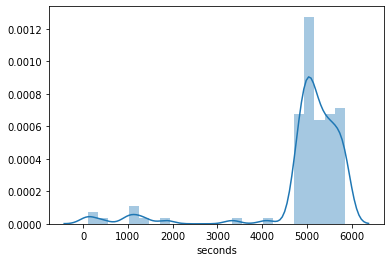

In [24]:
sns.distplot(full_df.seconds)

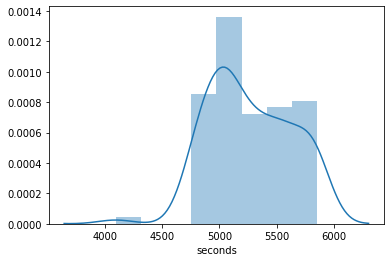

In [25]:
# Cut off the people who finished under 4000 seconds
shortened_df = full_df[full_df.seconds > 4000]
sns.distplot(shortened_df.seconds)

In [26]:
shortened_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
1,1032,2020-07-12,2020,Styrian Grand Prix,8,5008.802,1,0,0,0,0,16,81.140,1,0,0,0,0,0,0,0,0,0,\N,0.0,53,225.185,0.0,14,0,2.0,7.0,0.0,69.031
3,1032,2020-07-12,2020,Styrian Grand Prix,154,5009.618,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0,0,\N,0.0,49,221.347,0.0,16,0,0.0,10.0,0.0,70.228
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
5,1032,2020-07-12,2020,Styrian Grand Prix,817,5033.274,1,0,0,0,0,8,79.229,0,0,0,0,0,0,0,0,1,0,\N,0.0,17,220.150,0.0,19,0,4.0,6.0,0.0,70.610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,1037,2020-08-30,2020,Belgian Grand Prix,842,5096.132,0,0,0,0,1,12,102.745,0,1,0,0,0,0,0,0,0,0,9,2.0,65,203.021,14.0,13,0,16.0,7.0,0.0,82.543
111,1037,2020-08-30,2020,Belgian Grand Prix,844,5123.681,0,0,0,0,1,13,102.996,0,0,1,0,0,0,0,0,0,0,\N,0.0,38,199.576,45.0,4,0,61.0,5.0,0.0,83.968
112,1037,2020-08-30,2020,Belgian Grand Prix,846,5092.535,0,0,0,0,1,10,102.657,0,0,0,0,1,0,0,0,0,0,10,1.0,65,203.393,39.0,7,0,62.0,4.0,0.0,82.392
114,1037,2020-08-30,2020,Belgian Grand Prix,848,5091.473,0,0,0,0,1,5,102.193,0,0,0,0,0,0,0,1,0,0,8,4.0,65,203.883,40.0,6,0,135.0,2.0,1.0,82.194


In [27]:
# Delete rows where there are nans
shortened_df = shortened_df.replace({r"\N": None})
shortened_df = shortened_df.dropna()

# Create ratios for all the variables in terms of seconds and then create a rolling average for them over the season
min_df = shortened_df.groupby("raceId", as_index = False)
min_lap_time = min_df.fastestLapTime.min()
temp1 = pd.merge(shortened_df, min_lap_time, on = "raceId")  
temp1["fastestLapRatio"] = temp1["fastestLapTime_x"] / temp1["fastestLapTime_y"]
temp1 = temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
min_quali_time = min_df.minQualifyingTime.min()
temp2 = pd.merge(temp1, min_quali_time, on = "raceId")
temp2["minQualiRatio"] = temp2["minQualifyingTime_x"] / temp2["minQualifyingTime_y"]
temp2 = temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
temp2["avg_lap_time"] = temp2["seconds"] / temp2["laps"]
temp_min = temp2.groupby("raceId", as_index = False)
min_avg_lap_time = temp_min.avg_lap_time.min()
temp_min1 = pd.merge(temp2, min_avg_lap_time, on = "raceId")
temp_min1["avgLapRatio"] = temp_min1["avg_lap_time_x"] / temp_min1["avg_lap_time_y"]
temp_min1 = temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
temp3 = temp_min1.groupby("driverId", as_index = True)
rolling_fastLapRatio = pd.DataFrame(temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_fastLapRatio = rolling_fastLapRatio.reset_index()
rolling_fastLapRatio = rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
rolling_minQualiRatio = pd.DataFrame(temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_minQualiRatio = rolling_minQualiRatio.reset_index()
rolling_minQualiRatio = rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
rolling_avgLapRatio = pd.DataFrame(temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
rolling_avgLapRatio = rolling_avgLapRatio.reset_index()
rolling_avgLapRatio = rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
temp_min1 = temp_min1.reset_index()
temp4 = pd.merge(temp_min1, rolling_fastLapRatio, on = ["driverId", "index"])
temp5 = pd.merge(temp4, rolling_minQualiRatio, on = ["driverId", "index"])
temp6 = pd.merge(temp5, rolling_avgLapRatio, on = ["driverId", "index"])
temp6 = temp6.drop(columns = ["fastestLapRatio", "minQualiRatio", "avgLapRatio", "seconds", "laps"])

key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'rolling_avgLapTime')
sorted_df = temp6[sorted(temp6, key=key)]
sorted_df["rolling_avgLapTime"] = sorted_df["rolling_avgLapTime"] * 100
sorted_df["rolling_fastestLap"] = sorted_df["rolling_fastestLap"] * 100
sorted_df["rolling_minQualiRatio"] = sorted_df["rolling_minQualiRatio"] * 100
sorted_df

,index,raceId,date,year,raceName,driverId,rolling_avgLapTime,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,0,1032,2020-07-12,2020,Styrian Grand Prix,1,100.000000,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,4,12.0,229.572,12.0,4,0,37.0,1.0,1.0,100.351241,100.000000
1,1,1032,2020-07-12,2020,Styrian Grand Prix,815,101.255099,1,0,0,0,0,17,0,0,0,0,0,0,1,0,0,0,6,8.0,227.579,8.0,6,0,8.0,4.0,0.0,101.230085,104.859621
2,2,1032,2020-07-12,2020,Styrian Grand Prix,822,100.275998,1,0,0,0,0,4,0,0,0,0,0,1,0,0,0,0,1,25.0,229.758,25.0,1,1,37.0,1.0,1.0,100.269730,101.069065
3,3,1032,2020-07-12,2020,Styrian Grand Prix,826,103.524779,1,0,0,0,0,13,0,1,0,0,0,0,0,0,0,0,12,0.0,224.847,0.0,12,0,6.0,5.0,0.0,102.460170,102.431095
4,4,1032,2020-07-12,2020,Styrian Grand Prix,832,100.383106,1,0,0,0,0,3,0,0,0,0,1,0,0,0,0,0,5,10.0,228.687,10.0,5,0,26.0,2.0,0.0,100.739533,100.982975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,87,1037,2020-08-30,2020,Belgian Grand Prix,840,101.115884,0,0,0,0,1,9,0,0,0,0,0,0,1,0,0,0,4,12.0,204.306,40.0,5,0,63.0,3.0,0.0,103.593927,101.427531
88,88,1037,2020-08-30,2020,Belgian Grand Prix,842,101.469352,0,0,0,0,1,12,0,1,0,0,0,0,0,0,0,0,9,2.0,203.021,14.0,13,0,16.0,7.0,0.0,103.151581,101.467969
89,89,1037,2020-08-30,2020,Belgian Grand Prix,846,101.407366,0,0,0,0,1,10,0,0,0,0,1,0,0,0,0,0,10,1.0,203.393,39.0,7,0,62.0,4.0,0.0,103.008722,101.650394
90,90,1037,2020-08-30,2020,Belgian Grand Prix,848,102.138293,0,0,0,0,1,5,0,0,0,0,0,0,0,1,0,0,8,4.0,203.883,40.0,6,0,135.0,2.0,1.0,102.627942,101.977292


In [28]:
# Split x and y in training data
x = sorted_df.iloc[:, 7:]
x["fastestLapSpeed"] = pd.to_numeric(x["fastestLapSpeed"])
x["finishingPosition"] = pd.to_numeric(x["finishingPosition"])
y = sorted_df.iloc[:, 6]

### Creating the Test Data

In [20]:
# Doing the same for the most recent race, pulled in from Raw Predictive Modeling ipynb
be_df = pd.read_csv("./predictions/be_2020_raw_table").iloc[:, 1:]
past_race_lap_info = total_lap_info[total_lap_info.raceId == 1036]
past_race_lap_info["raceId"] = past_race_lap_info["raceId"] + 1
past_race_lap_info
be_merged_df = pd.merge(be_df, past_race_lap_info[["raceId", "driverId", "seconds"]], on = ["raceId", "driverId"])
be_merged_df

,raceId,driverId,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime,seconds
0,1037,1,0,0,0,0,1,1,101.252,0,0,0,0,0,1,0,0,0,0,1.0,25.0,66,209.942,132.0,1,4,221.0,1.0,5.0,79.822,5505.279
1,1037,822,0,0,0,0,1,2,101.763,0,0,0,0,0,1,0,0,0,0,3.0,16.0,66,214.343,89.0,3,1,221.0,1.0,5.0,78.183,5550.031
2,1037,830,0,0,0,0,1,3,101.778,0,0,0,0,0,0,0,1,0,0,2.0,18.0,66,205.677,95.0,2,1,135.0,2.0,1.0,81.477,5529.456
3,1037,848,0,0,0,0,1,5,102.193,0,0,0,0,0,0,0,1,0,0,8.0,4.0,65,203.883,40.0,6,0,135.0,2.0,1.0,82.194,5545.008
4,1037,817,0,0,0,0,1,4,102.061,0,0,0,0,0,0,0,0,1,0,11.0,0.0,65,203.215,20.0,10,0,36.0,6.0,0.0,82.464,5547.145
5,1037,839,0,0,0,0,1,6,102.396,0,0,0,0,0,0,0,0,1,0,13.0,0.0,65,203.933,16.0,12,0,36.0,6.0,0.0,82.174,5561.207
6,1037,832,0,0,0,0,1,7,102.438,0,0,0,0,1,0,0,0,0,0,6.0,8.0,65,204.938,23.0,9,0,62.0,4.0,0.0,81.771,5531.045
7,1037,846,0,0,0,0,1,10,102.657,0,0,0,0,1,0,0,0,0,0,10.0,1.0,65,203.393,39.0,7,0,62.0,4.0,0.0,82.392,5546.154
8,1037,815,0,0,0,0,1,8,102.532,0,0,0,0,0,0,1,0,0,0,5.0,10.0,65,203.090,32.0,8,0,63.0,3.0,0.0,82.515,5524.464
9,1037,840,0,0,0,0,1,9,102.491,0,0,0,0,0,0,1,0,0,0,4.0,12.0,65,204.306,40.0,5,0,63.0,3.0,0.0,82.024,5526.724


In [21]:
current_min_df.minQualifyingTime.min()

,raceId,minQualifyingTime
0,1037,101.252


In [38]:
current_min_df = be_merged_df.groupby("raceId", as_index = False)
current_min_lap_time = current_min_df.fastestLapTime.min()
current_temp1 = pd.merge(be_merged_df, current_min_lap_time, on = "raceId")  
current_temp1["fastestLapRatio"] = current_temp1["fastestLapTime_x"] / current_temp1["fastestLapTime_y"]
current_temp1 = current_temp1.drop(columns = ["fastestLapTime_x", "fastestLapTime_y"])
current_min_quali_time = current_min_df.minQualifyingTime.min()
current_temp2 = pd.merge(current_temp1, current_min_quali_time, on = "raceId")
current_temp2["minQualiRatio"] = current_temp2["minQualifyingTime_x"] / current_temp2["minQualifyingTime_y"]
current_temp2 = current_temp2.drop(columns = ["minQualifyingTime_x", "minQualifyingTime_y"])
current_temp2["avg_lap_time"] = current_temp2["seconds"] / current_temp2["laps"]
current_temp_min = current_temp2.groupby("raceId", as_index = False)
current_min_avg_lap_time = current_temp_min.avg_lap_time.min()
current_temp_min1 = pd.merge(current_temp2, current_min_avg_lap_time, on = "raceId")
current_temp_min1["avgLapRatio"] = current_temp_min1["avg_lap_time_x"] / current_temp_min1["avg_lap_time_y"]
current_temp_min1 = current_temp_min1.drop(columns = ["avg_lap_time_x", "avg_lap_time_y"])
current_temp3 = current_temp_min1.groupby("driverId", as_index = True)
current_rolling_fastLapRatio = pd.DataFrame(current_temp3["fastestLapRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_fastLapRatio = current_rolling_fastLapRatio.reset_index()
current_rolling_fastLapRatio = current_rolling_fastLapRatio.rename({"level_1" : "index", "fastestLapRatio" : "rolling_fastestLap"}, axis = 1)
current_rolling_minQualiRatio = pd.DataFrame(current_temp3["minQualiRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_minQualiRatio = current_rolling_minQualiRatio.reset_index()
current_rolling_minQualiRatio = current_rolling_minQualiRatio.rename({"level_1" : "index", "minQualiRatio" : "rolling_minQualiRatio"}, axis = 1)
current_rolling_avgLapRatio = pd.DataFrame(current_temp3["avgLapRatio"].rolling(window = 50, min_periods = 1).mean())
current_rolling_avgLapRatio = current_rolling_avgLapRatio.reset_index()
current_rolling_avgLapRatio = current_rolling_avgLapRatio.rename({"level_1" : "index", "avgLapRatio" : "rolling_avgLapTime"}, axis = 1)
current_temp_min1 = current_temp_min1.reset_index()
current_temp4 = pd.merge(current_temp_min1, current_rolling_fastLapRatio, on = ["driverId", "index"])
current_temp5 = pd.merge(current_temp4, current_rolling_minQualiRatio, on = ["driverId", "index"])
current_temp6 = pd.merge(current_temp5, current_rolling_avgLapRatio, on = ["driverId", "index"])
current_temp6 = current_temp6.drop(columns = ["fastestLapRatio", "minQualiRatio", "avgLapRatio", "seconds", "laps"])

key = lambda x: (x != 'index', x != 'raceId', x != 'date', x != 'year', x != 'raceName', x != 'driverId', x != 'rolling_avgLapTime')
current_sorted_df = current_temp6[sorted(current_temp6, key=key)]
current_sorted_df["rolling_avgLapTime"] = current_sorted_df["rolling_avgLapTime"] * 100
current_sorted_df["rolling_fastestLap"] = current_sorted_df["rolling_fastestLap"] * 100
current_sorted_df["rolling_minQualiRatio"] = current_sorted_df["rolling_minQualiRatio"] * 100
current_sorted_df = current_sorted_df.dropna()
current_sorted_df

,index,raceId,driverId,rolling_avgLapTime,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,rolling_fastestLap,rolling_minQualiRatio
0,0,1037,1,100.000000,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1.0,25.0,209.942,132.0,1,4,221.0,1.0,5.0,102.096364,100.000000
1,1,1037,822,100.812892,0,0,0,0,1,2,0,0,0,0,0,1,0,0,0,0,3.0,16.0,214.343,89.0,3,1,221.0,1.0,5.0,100.000000,100.504681
2,2,1037,830,100.439160,0,0,0,0,1,3,0,0,0,0,0,0,0,1,0,0,2.0,18.0,205.677,95.0,2,1,135.0,2.0,1.0,104.213192,100.519496
3,3,1037,848,102.271217,0,0,0,0,1,5,0,0,0,0,0,0,0,1,0,0,8.0,4.0,203.883,40.0,6,0,135.0,2.0,1.0,105.130271,100.929364
4,4,1037,817,102.310631,0,0,0,0,1,4,0,0,0,0,0,0,0,0,1,0,11.0,0.0,203.215,20.0,10,0,36.0,6.0,0.0,105.475615,100.798997
5,5,1037,839,102.569988,0,0,0,0,1,6,0,0,0,0,0,0,0,0,1,0,13.0,0.0,203.933,16.0,12,0,36.0,6.0,0.0,105.104690,101.129854
6,6,1037,832,102.013685,0,0,0,0,1,7,0,0,0,0,1,0,0,0,0,0,6.0,8.0,204.938,23.0,9,0,62.0,4.0,0.0,104.589233,101.171335
7,7,1037,846,102.292353,0,0,0,0,1,10,0,0,0,0,1,0,0,0,0,0,10.0,1.0,203.393,39.0,7,0,62.0,4.0,0.0,105.383523,101.387627
8,8,1037,815,101.892307,0,0,0,0,1,8,0,0,0,0,0,0,1,0,0,0,5.0,10.0,203.090,32.0,8,0,63.0,3.0,0.0,105.540846,101.264173
9,9,1037,840,101.933990,0,0,0,0,1,9,0,0,0,0,0,0,1,0,0,0,4.0,12.0,204.306,40.0,5,0,63.0,3.0,0.0,104.912833,101.223680


In [44]:
x_test = current_sorted_df.iloc[:, 4:]

### Linear Regression

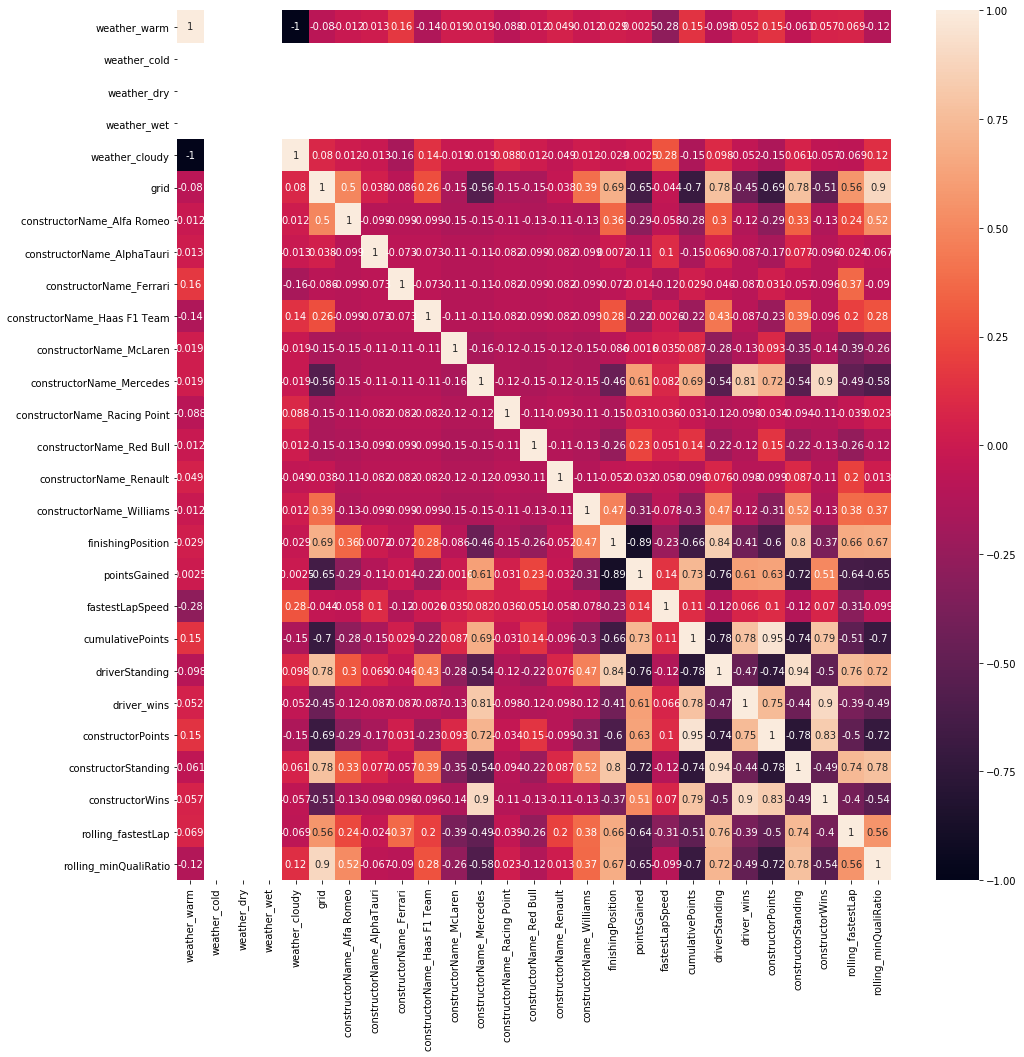

In [26]:
# Check for correlation among the variables
corrMatrix = x.corr()
pyplot.figure(figsize=(16, 16))
sns.heatmap(corrMatrix, annot=True)

In [27]:
# correlated_features = set()

# for i in range(len(corrMatrix.columns)):
#     for j in range(i):
#         if abs(corrMatrix.iloc[i, j]) > 0.8:
#             colname = corrMatrix.columns[i]
#             correlated_features.add(colname)

# correlated_features

In [28]:
# # Remove correlated features from the model
# x = x.drop(labels = correlated_features, axis=1)
# test_x = test_x.drop(labels = correlated_features, axis=1)

In [36]:
lr_model = LinearRegression()
lr_model.fit(x, y)
lr_model.score(x, y)

0.7792143855132131

In [47]:
# Predict based on the model with linear regression
lr_preds = lr_model.predict(x_test)
lr_preds_df = pd.DataFrame({'Predictions' : lr_preds})
merged_lr_df = pd.merge(lr_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_lr_df = pd.merge(merged_lr_df, drivers[["driverName", "driverId"]], on = "driverId")
full_lr_df.sort_values("Predictions")

,Predictions,raceId,driverId,driverName
1,99.927807,1037,822,Valtteri Bottas
0,100.088467,1037,1,Lewis Hamilton
9,100.525282,1037,840,Lance Stroll
2,100.734370,1037,830,Max Verstappen
8,100.925031,1037,815,Sergio Pérez
4,101.104697,1037,817,Daniel Ricciardo
5,101.467778,1037,839,Esteban Ocon
6,102.380049,1037,832,Carlos Sainz
16,102.429030,1037,841,Antonio Giovinazzi
7,102.468402,1037,846,Lando Norris


In [49]:
lr_coef_df = pd.DataFrame({"Variables" : x_test.columns, "Coefficients" : lr_model.coef_})
lr_coef_df["abs_coefficients"] = np.abs(lr_coef_df.Coefficients)
lr_coef_df.sort_values("abs_coefficients", ascending = False)

,Variables,Coefficients,abs_coefficients
13,constructorName_Red Bull,2.954212e+00,2.954212e+00
9,constructorName_Haas F1 Team,-2.542454e+00,2.542454e+00
15,constructorName_Williams,-2.083021e+00,2.083021e+00
6,constructorName_Alfa Romeo,-1.920699e+00,1.920699e+00
10,constructorName_McLaren,1.727040e+00,1.727040e+00
11,constructorName_Mercedes,1.363063e+00,1.363063e+00
14,constructorName_Renault,-7.256353e-01,7.256353e-01
8,constructorName_Ferrari,6.686969e-01,6.686969e-01
12,constructorName_Racing Point,6.499923e-01,6.499923e-01
24,constructorWins,6.259486e-01,6.259486e-01


### Random Forest

In [50]:
# Random Forest regression on this data to predict results for the 2020 Spanish Grand Prix
model = RandomForestRegressor(n_estimators = 300, max_depth = 9, random_state = 1)
model.fit(x, y)
model.score(x, y)

0.9187077046489848

In [52]:
# Predict on x_test
sp_preds = model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
merged_sp_df = pd.merge(sp_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
full_sp_df.sort_values("Predictions")

,Predictions,raceId,driverId,driverName
0,100.358035,1037,1,Lewis Hamilton
1,100.364595,1037,822,Valtteri Bottas
2,100.650273,1037,830,Max Verstappen
4,101.186738,1037,817,Daniel Ricciardo
8,101.254900,1037,815,Sergio Pérez
9,101.339822,1037,840,Lance Stroll
6,101.345242,1037,832,Carlos Sainz
3,101.388284,1037,848,Alexander Albon
7,101.456435,1037,846,Lando Norris
5,101.523518,1037,839,Esteban Ocon


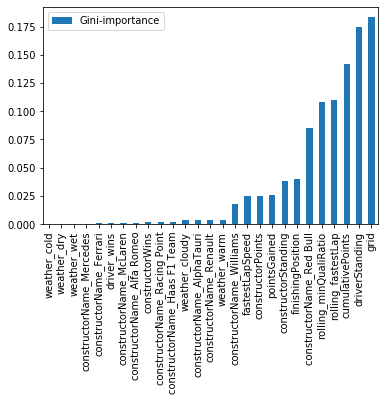

In [53]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, model.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance').plot(kind='bar', rot=90)

In [54]:
importances.sort_values("Gini-importance", ascending = False).head(10)

,Gini-importance
grid,0.183335
driverStanding,0.174574
cumulativePoints,0.141777
rolling_fastestLap,0.110219
rolling_minQualiRatio,0.108372
constructorName_Red Bull,0.085442
finishingPosition,0.040017
constructorStanding,0.038123
pointsGained,0.025642
constructorPoints,0.025121


### XGBoost

In [55]:
xgb_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9)
xgb_model.fit(x, y)
xgb_model.score(x, y)

0.9999997692992807

In [58]:
xgb_preds = xgb_model.predict(x_test)
xgb_preds_df = pd.DataFrame({'Predictions' : xgb_preds})
merged_xgb_df = pd.merge(xgb_preds_df, current_sorted_df[["raceId", "driverId"]], left_index = True, right_index = True)
full_xgb_df = pd.merge(merged_xgb_df, drivers[["driverName", "driverId"]], on = "driverId")
full_xgb_df = full_xgb_df.sort_values("Predictions")
full_xgb_df = full_xgb_df.reset_index(drop = True)
full_xgb_df["Predicted Position"] = full_xgb_df.index + 1
full_xgb_df

,Predictions,raceId,driverId,driverName,Predicted Position
0,99.707321,1037,830,Max Verstappen,1
1,100.101273,1037,1,Lewis Hamilton,2
2,100.432915,1037,822,Valtteri Bottas,3
3,100.826454,1037,817,Daniel Ricciardo,4
4,101.092072,1037,848,Alexander Albon,5
5,101.330887,1037,839,Esteban Ocon,6
6,101.448029,1037,8,Kimi Räikkönen,7
7,101.543747,1037,840,Lance Stroll,8
8,101.552269,1037,815,Sergio Pérez,9
9,101.564987,1037,832,Carlos Sainz,10


In [59]:
# Save this into a CSV
be_2020_pr_predictions = full_xgb_df[["Predicted Position", "driverName"]]
be_2020_pr_predictions = be_2020_pr_predictions.rename({"driverName" : "Driver Name"})
be_2020_pr_predictions.to_csv("./predictions/be_2020_pr_predictions.csv")

# Predictions on the Unprocessed Dataframe with Raw Seconds

In [208]:
shortened_df

,raceId,date,year,raceName,driverId,seconds,weather_warm,weather_cold,weather_dry,weather_wet,weather_cloudy,grid,minQualifyingTime,constructorName_Alfa Romeo,constructorName_AlphaTauri,constructorName_Ferrari,constructorName_Haas F1 Team,constructorName_McLaren,constructorName_Mercedes,constructorName_Racing Point,constructorName_Red Bull,constructorName_Renault,constructorName_Williams,finishingPosition,pointsGained,laps,fastestLapSpeed,cumulativePoints,driverStanding,driver_wins,constructorPoints,constructorStanding,constructorWins,fastestLapTime
0,1032,2020-07-12,2020,Styrian Grand Prix,1,4970.683,1,0,0,0,0,1,77.825,0,0,0,0,0,1,0,0,0,0,4,12.0,71,229.572,12.0,4,0,37.0,1.0,1.0,67.712
4,1032,2020-07-12,2020,Styrian Grand Prix,815,5033.070,1,0,0,0,0,17,81.607,0,0,0,0,0,0,1,0,0,0,6,8.0,71,227.579,8.0,6,0,8.0,4.0,0.0,68.305
6,1032,2020-07-12,2020,Styrian Grand Prix,822,4984.402,1,0,0,0,0,4,78.657,0,0,0,0,0,1,0,0,0,0,1,25.0,71,229.758,25.0,1,1,37.0,1.0,1.0,67.657
8,1032,2020-07-12,2020,Styrian Grand Prix,826,5000.934,1,0,0,0,0,13,79.717,0,1,0,0,0,0,0,0,0,0,12,0.0,69,224.847,0.0,12,0,6.0,5.0,0.0,69.135
10,1032,2020-07-12,2020,Styrian Grand Prix,832,4989.726,1,0,0,0,0,3,78.590,0,0,0,0,1,0,0,0,0,0,5,10.0,71,228.687,10.0,5,0,26.0,2.0,0.0,67.974
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,1036,2020-08-16,2020,Spanish Grand Prix,844,3331.636,1,0,0,0,0,9,76.953,0,0,1,0,0,0,0,0,0,0,4,12.0,52,234.203,45.0,4,0,55.0,3.0,0.0,90.552
93,1036,2020-08-16,2020,Spanish Grand Prix,846,5546.154,1,0,0,0,0,8,77.084,0,0,0,0,1,0,0,0,0,0,9,2.0,52,233.826,38.0,5,0,53.0,4.0,0.0,90.698
94,1036,2020-08-16,2020,Spanish Grand Prix,847,5584.656,1,0,0,0,0,18,78.099,0,0,0,0,0,0,0,0,0,1,18,0.0,51,232.010,0.0,20,0,0.0,10.0,0.0,91.408
95,1036,2020-08-16,2020,Spanish Grand Prix,848,5545.008,1,0,0,0,0,6,77.029,0,0,0,0,0,0,0,1,0,0,5,10.0,52,237.017,36.0,6,0,113.0,2.0,1.0,89.477


In [221]:
unp_training_df = shortened_df[shortened_df.raceId != 1036]
unp_test_df = shortened_df[shortened_df.raceId == 1036]

# Split into x and y
unp_x = unp_training_df.iloc[:, 6:]
unp_y = unp_training_df.iloc[:, 5]
unp_x["fastestLapSpeed"] = pd.to_numeric(unp_x["fastestLapSpeed"])
unp_x["finishingPosition"] = pd.to_numeric(unp_x["finishingPosition"])

# Same for the test data
unp_test_x = unp_test_df.iloc[:, 6:]
unp_test_y = unp_test_df.iloc[:, 5]
unp_test_x["fastestLapSpeed"] = pd.to_numeric(unp_test_x["fastestLapSpeed"])
unp_test_x["finishingPosition"] = pd.to_numeric(unp_test_x["finishingPosition"])

### Linear Regression

In [222]:
lr_model.fit(unp_x, unp_y)
lr_model.score(unp_x, unp_y)

0.9980497802846171

In [223]:
# Predict based on the model with linear regression
lr_preds = lr_model.predict(unp_test_x)
lr_preds_df = pd.DataFrame({'Predictions' : lr_preds})
merged_lr_df = pd.merge(lr_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_lr_df = pd.merge(merged_lr_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_lr_df["driverName"])):
    if full_lr_df["driverName"][i] == "Sergio Pérez":
        full_lr_df["laps"][i] = 52.0   
full_lr_df["avg_lap_time"] = full_lr_df["Predictions"] / full_lr_df.laps

full_lr_df.sort_values("avg_lap_time")

,Predictions,raceId,driverId,laps,driverName,avg_lap_time
0,4647.345430,1036,1,52.0,Lewis Hamilton,89.372027
13,4674.816185,1036,839,52.0,Esteban Ocon,89.900311
4,4675.435475,1036,815,52.0,Sergio Pérez,89.912221
9,4679.572292,1036,20,52.0,Sebastian Vettel,89.991775
3,4684.789702,1036,848,52.0,Alexander Albon,90.092110
1,4690.515486,1036,822,52.0,Valtteri Bottas,90.202221
10,4692.456807,1036,842,52.0,Pierre Gasly,90.239554
11,4701.552479,1036,826,52.0,Daniil Kvyat,90.414471
6,4707.172421,1036,832,52.0,Carlos Sainz,90.522547
7,4708.375280,1036,846,52.0,Lando Norris,90.545678


### Random Forest

In [224]:
model.fit(unp_x, unp_y)
model.score(unp_x, unp_y)

0.999537012443627

In [225]:
sp_preds = model.predict(unp_test_x)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_sp_df["driverName"])):
    if full_sp_df["driverName"][i] == "Sergio Pérez":
        full_sp_df["laps"][i] = 52.0   
full_sp_df["avg_lap_time"] = full_sp_df["Predictions"] / full_sp_df.laps

full_sp_df.sort_values("avg_lap_time")

,Predictions,raceId,driverId,laps,driverName,avg_lap_time
3,4853.441531,1036,848,52.0,Alexander Albon,93.335414
9,4880.303872,1036,20,52.0,Sebastian Vettel,93.851998
11,4903.157279,1036,826,52.0,Daniil Kvyat,94.291486
17,4852.515350,1036,154,51.0,Romain Grosjean,95.147360
15,4858.503402,1036,841,51.0,Antonio Giovinazzi,95.264773
1,4993.484480,1036,822,52.0,Valtteri Bottas,96.028548
6,5091.157765,1036,832,52.0,Carlos Sainz,97.906880
4,5092.119163,1036,815,52.0,Sergio Pérez,97.925369
2,5093.291943,1036,830,52.0,Max Verstappen,97.947922
0,5164.081770,1036,1,52.0,Lewis Hamilton,99.309265


### XGBoost

In [230]:
unp_x = shortened_df.iloc[:, 6:]
unp_x = unp_x.drop(columns = "laps")
unp_x["fastestLapSpeed"] = pd.to_numeric(unp_x["fastestLapSpeed"])
unp_x["finishingPosition"] = pd.to_numeric(unp_x["finishingPosition"])
unp_y = shortened_df.iloc[:, 5]

In [238]:
xgb_model = xgb.XGBRegressor(n_estimators = 300, max_depth = 9, random_state = 1)
xgb_model.fit(unp_x, unp_y)
xgb_model.score(unp_x, unp_y)

0.9999999999968049

In [239]:
# Create df for Spanish Grand Prix
# Take final_df from all the merging done before
training_df1 = final_df[final_df.raceId == 1035]
# Get the minimum qualifying time from each driver for the Spanish Grand Prix
sp_quali_df = qualifying[qualifying.raceId == 1036]
sp_quali_df["minQualifyingTime"] = sp_quali_df[["q1", "q2", "q3"]].min(skipna = True, axis = 1)
sp_quali_df = sp_quali_df.drop(columns = ["q1", "q2", "q3"])
# Convert to seconds
for i in range(len(sp_quali_df['minQualifyingTime'])):
    if  sp_quali_df['minQualifyingTime'].iloc[i] != 0:
        sp_quali_df['minQualifyingTime'].iloc[i] = float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[1]) + (60 * float(str(sp_quali_df['minQualifyingTime'].iloc[i]).split(':')[0]))
        i += 1
    else:
        sp_quali_df['minQualifyingTime'].iloc[i] = None
        i += 1
# Match the constructorId to the constructorName
sp_quali_df1 = pd.merge(sp_quali_df, constructors[["constructorId", "name"]], on = "constructorId")
sp_quali_df1 = sp_quali_df1.rename({'name' : 'constructorName', 'position': 'grid'}, axis = 1)
sp_quali_df1 = pd.get_dummies(sp_quali_df1, columns = ['constructorName'])
sp_quali_df2 = pd.merge(sp_quali_df1, weather_info, on = "raceId")

# Rearrange this df so it's in the same format 
sp_quali_df2 = sp_quali_df2[["raceId", "driverId", "weather_warm", "weather_cold", "weather_dry", "weather_wet",
                             "weather_cloudy", "grid", "minQualifyingTime", "constructorName_Alfa Romeo", 
                             "constructorName_AlphaTauri", "constructorName_Ferrari", "constructorName_Haas F1 Team",
                             "constructorName_McLaren", "constructorName_Mercedes", "constructorName_Racing Point",
                             "constructorName_Red Bull", "constructorName_Renault", "constructorName_Williams"]]
x_test1 = pd.merge(sp_quali_df2, past_df[["raceId", "driverId", "finishingPosition", "pointsGained", "laps", "fastestLapSpeed",
                                     "cumulativePoints", "driverStanding", "driver_wins", "constructorPoints",
                                     "constructorStanding", "constructorWins", "fastestLapTime"]], on = ["raceId", "driverId"], how = "left")
x_test1 = x_test1.replace({r"\N": None})
# x_test1 = x_test1.dropna()
x_test = x_test1.iloc[:, 2:]
x_test["fastestLapSpeed"] = pd.to_numeric(x_test["fastestLapSpeed"])
x_test["finishingPosition"] = pd.to_numeric(x_test["finishingPosition"])
x_test = x_test.drop(columns = "laps")

In [241]:
# Predict on x_test
sp_preds = xgb_model.predict(x_test)
sp_preds_df = pd.DataFrame({'Predictions' : sp_preds})
sp_preds_df
merged_sp_df = pd.merge(sp_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_sp_df = pd.merge(merged_sp_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_sp_df["driverName"])):
    if full_sp_df["driverName"][i] == "Sergio Pérez":
        full_sp_df["laps"][i] = 52.0   
full_sp_df["avg_pred_lap"] = full_sp_df.Predictions / full_sp_df.laps
full_sp_df.sort_values("avg_pred_lap")

,Predictions,raceId,driverId,laps,driverName,avg_pred_lap
8,3331.636475,1036,844,52.0,Charles Leclerc,64.069932
4,5500.301270,1036,815,52.0,Sergio Pérez,105.775024
0,5505.277832,1036,1,52.0,Lewis Hamilton,105.870728
5,5526.724121,1036,840,52.0,Lance Stroll,106.283156
2,5529.457031,1036,830,52.0,Max Verstappen,106.335712
6,5531.045410,1036,832,52.0,Carlos Sainz,106.366258
9,5543.810547,1036,20,52.0,Sebastian Vettel,106.611741
3,5545.007324,1036,848,52.0,Alexander Albon,106.634756
10,5545.597168,1036,842,52.0,Pierre Gasly,106.646099
7,5546.153320,1036,846,52.0,Lando Norris,106.656795


In [249]:
xgb_preds = xgb_model.predict(unp_test_x)
xgb_preds_df = pd.DataFrame({'Predictions' : xgb_preds})
merged_xgb_df = pd.merge(xgb_preds_df, x_test1[["raceId", "driverId", "laps"]], left_index = True, right_index = True)
full_xgb_df = pd.merge(merged_xgb_df, drivers[["driverName", "driverId"]], on = "driverId")
for i in range(len(full_xgb_df["driverName"])):
    if full_xgb_df["driverName"][i] == "Sergio Pérez":
        full_xgb_df["laps"][i] = 52.0   
full_xgb_df["avg_lap_time"] = full_xgb_df["Predictions"] / full_xgb_df.laps

full_xgb_df.sort_values("avg_lap_time")

ValueError: feature_names mismatch: ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy', 'grid', 'minQualifyingTime', 'constructorName_Alfa Romeo', 'constructorName_AlphaTauri', 'constructorName_Ferrari', 'constructorName_Haas F1 Team', 'constructorName_McLaren', 'constructorName_Mercedes', 'constructorName_Racing Point', 'constructorName_Red Bull', 'constructorName_Renault', 'constructorName_Williams', 'finishingPosition', 'pointsGained', 'fastestLapSpeed', 'cumulativePoints', 'driverStanding', 'driver_wins', 'constructorPoints', 'constructorStanding', 'constructorWins', 'fastestLapTime'] ['weather_warm', 'weather_cold', 'weather_dry', 'weather_wet', 'weather_cloudy', 'grid', 'minQualifyingTime', 'constructorName_Alfa Romeo', 'constructorName_AlphaTauri', 'constructorName_Ferrari', 'constructorName_Haas F1 Team', 'constructorName_McLaren', 'constructorName_Mercedes', 'constructorName_Racing Point', 'constructorName_Red Bull', 'constructorName_Renault', 'constructorName_Williams', 'finishingPosition', 'pointsGained', 'laps', 'fastestLapSpeed', 'cumulativePoints', 'driverStanding', 'driver_wins', 'constructorPoints', 'constructorStanding', 'constructorWins', 'fastestLapTime']
training data did not have the following fields: laps

In [248]:
# Save the XGB results to a CSV
full_xgb_df = full_xgb_df.reset_index(drop = True)
full_xgb_df["Predicted Position"] = full_xgb_df.index + 1
full_xgb_df
# sp_2020_pr_predictions = full_xgb_df[["Predicted Position", "driverName"]]
# sp_2020_pr_predictions = sp_2020_pr_predictions.rename({"driverName" : "Driver Name"}, axis = 1)
# sp_2020_pr_predictions

,Predictions,raceId,driverId,laps,driverName,avg_lap_time,Predicted Position
0,4794.212891,1036,1,52.0,Lewis Hamilton,92.196402,1
1,4820.951660,1036,822,52.0,Valtteri Bottas,92.710609,2
2,4847.411621,1036,830,52.0,Max Verstappen,93.219454,3
3,4817.874512,1036,848,52.0,Alexander Albon,92.651433,4
4,4831.724121,1036,815,52.0,Sergio Pérez,92.917772,5
5,4800.882812,1036,840,52.0,Lance Stroll,92.324669,6
6,4824.769531,1036,832,52.0,Carlos Sainz,92.784029,7
7,4795.319336,1036,846,52.0,Lando Norris,92.217680,8
8,4839.356445,1036,844,52.0,Charles Leclerc,93.064547,9
9,4841.572754,1036,20,52.0,Sebastian Vettel,93.107168,10


In [245]:
sp_2020_pr_predictions.to_csv("./predictions/sp_2020_pr_predictions.csv")